# Comparison of bubble trajectories

Start by loading some boiler plate: matplotlib, numpy, scipy, json, functools, and a convenience class.

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
import matplotlib.pyplot as plt
import numpy as np
import json
from functools import partial
class Foo: pass

And some more specialized dependencies:
 1. ``Slict`` provides a convenient slice-able dictionary interface
 2. ``Chest`` is an out-of-core dictionary that we'll hook directly to a globus remote using...
 3. ``glopen`` is an open-like context manager for remote globus files

In [2]:
from chest import Chest
from slict import CachedSlict
from glopen import glopen, glopen_many

Helper routines

In [3]:
def load_from_archive(names, arch):
    cs = []
    for name in names:
        cs.append(Chest(path      = "{:s}-results".format(name),
                        open      = partial(glopen,      endpoint=arch),
                        open_many = partial(glopen_many, endpoint=arch),
                        available_memory = 1e12))
    scs = [CachedSlict(c) for c in cs]

    ps = []
    for name in names:
        with glopen(
                    "{:s}.json".format(name), mode='r',
                    endpoint = arch,
                    ) as f:
            ps.append(json.load(f))
    if len(names) == 1:
        return cs[0], scs[0], ps[0]
    return cs, scs, ps

Configuration for this figure.  `config.ref` points to a simulation with periodic boundaries.

In [4]:
config = Foo()
config.names = [
#    "Wilk/Wilk_kmin_2.5/Wilk_kmin_2.5",
#    "Wilk/Wilk_kmin_3.5/Wilk_kmin_3.5", 
    "Wilk/Wilk_kmin_4.5/Wilk_kmin_4.5", 
#    "Wilk/Wilk_long/Wilk_long",
#    "Wilk/Wilk_per/Wilk_per",
]
config.arch_end = "maxhutch#alpha-admin/~/pub/"
#config.arch_end = "alcf#dtn_mira/projects/alpha-nek/experiments/"
#config.arch_end = "alcf#dtn_mira/projects/PetaCESAR/maxhutch/"

Open a chest located on a remote globus endpoint and load a remote json configuration file.

In [5]:
c, sc, p = load_from_archive(config.names, config.arch_end);

We want to plot the overall spike depth, which is the `H_exp` field in the chest, and the depth for individual spikes, `H_exp_cell`.

`H_exp = max(H_exp_cell)`

In [6]:
c.prefetch(sc[:,'w_xy'].full_keys() + sc[:,'z_z'].full_keys() )

<function __main__.plot_profile>

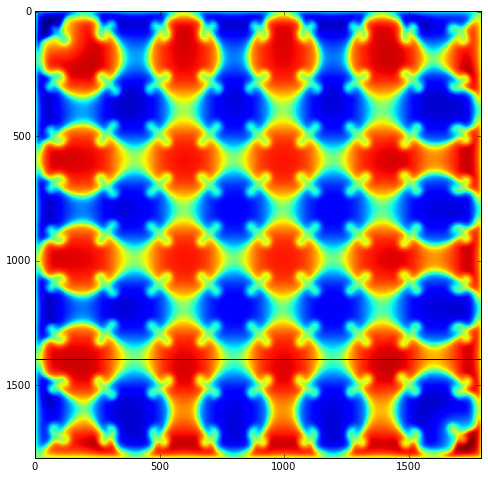

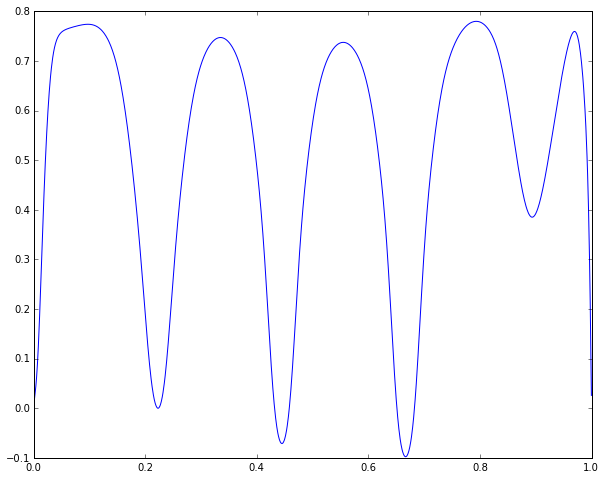

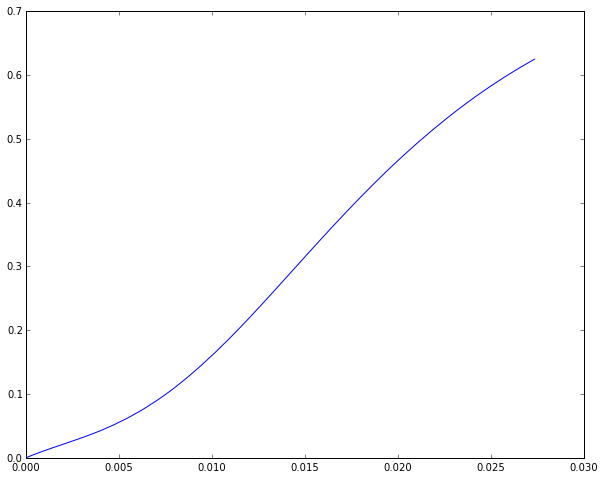

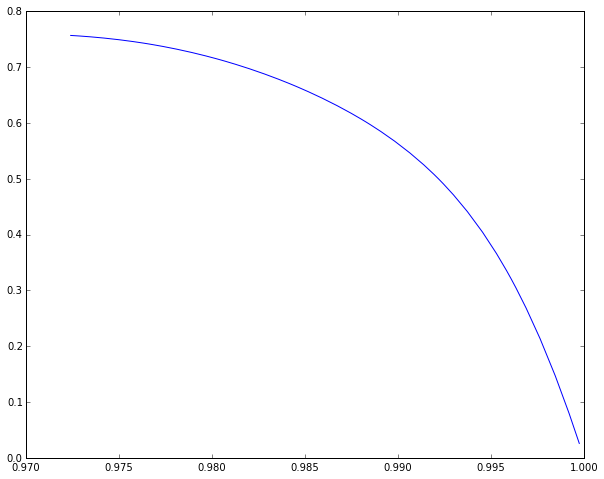

In [7]:
from IPython.html.widgets import interact, IntSlider
def plot_profile(frame, index):
    T = sc[:,'w_xy'].keys()[frame]
    data = sc[T,'w_xy']
    x = sc[0.0,'z_z'][-data.shape[0]:]

    plt.imshow(data)
    plt.axhline(index, color='k')
    plt.figure()
    plt.plot(x,data[index,:])
    plt.figure()
    plt.plot(x[:50],data[index,:50])
    plt.figure()
    plt.plot(x[-50:],data[index,-50:])

interact(plot_profile, 
         frame=(0,64), 
         index=IntSlider(min=0,max=sc[0.0,'w_xy'].shape[0]-1,step=8,value=int(sc[0.0,'w_xy'].shape[0]*7/9))
        )

In [8]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py 
%load_ext version_information 
%version_information numpy, matplotlib, slict, chest, glopen, globussh

Installed version_information.py. To use it, type:
  %load_ext version_information


/home/maxhutch/anaconda3/lib/python3.4/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension(s)as a python packages.
  "as a python packages.", UserWarning)


Software versions
Python 3.4.3 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 4.0.0
OS Linux 3.16.0 4 amd64 x86_64 with debian 8.2
numpy 1.9.3
matplotlib 1.4.3
slict 0.2.5
chest 0.2.2
glopen 0.0.12
globussh 0.1.2
Tue Dec 01 13:24:13 2015 CST